<a href="https://colab.research.google.com/github/dkanh6/EIS-ML/blob/main/mEIS_final_8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Problem at Hand:**
We need to extract, clean, and merge experimental data from multiple sources (TXT files and excel files)

**Research Questions:**
- **Binary Detection:** Develop an ML model to distinguish the presence vs. absence of bacteria using EIS data.
- **Viability Classification:** Classify bacterial samples based on their growth state (active growth vs. cell death) using impedance spectra.



# **General Data Structure:**
1. **TXT Files:**

  *  **Header:** Contains metadata

  *  **Trace A:** Holds the impedance frequency values and the REAL part of the impedance.

  *  **Trace B:** Holds the IMAGINARY part of the impedance

2. **Excel Files:**
  Contain full experiment details (contains circuit paramters such as capacitance values in the CPEb-T(+) column) and reference the TXT files via a file path embedded in a “Model:” column.
3. **Directory Structure:**
  The data is organized in a hierarchical structure under the root folder (Data).

  * **Experiments:**
    1. Control test (no bacteria)
    2. Test 5E2 (questionable death)
    3. Test 5E3 (marginal death data)
    4. Test 5E4 (death data)
    5. Test 5E5 (death data)

  * Each experiment represents a different starting bacterial concentration (from 5E2 CFU to 5E5 CFU).

  * Within Each Experiment:
    * There are 3 Cartridges (Cartridge 1, 2, and 3).
    * Each cartridge is measured at 12 timepoints (30 minutes apart).
    * For each timepoint, 5 samples are taken (e.g., files named 1-1-1.txt, 1-1-2.txt, … for Cartridge 1 at timepoint 1).


In [1]:
# 1) Clone the repository
!git clone https://github.com/dkanh6/EIS-ML.git
%cd EIS-ML

import os
import glob
import pandas as pd
import numpy as np
import re

def extract_exp_key(filename):
    match = re.search(r'(\d+-\d+-\d+)', filename)
    if match:
        return match.group(1).strip().lower()
    return ""



def parse_path_metadata(filepath):
    # Split the complete file path into a list using the OS separator.
    parts = filepath.split(os.sep)
    # If there are fewer than 3 parts, we cannot extract everything so jsut return defaults.
    if len(parts) < 3:
        return None, None, None, None, ""
    # The experiment folder is the third-to-last part in the path.
    experiment_folder = parts[-3]
    # The cartridge folder is the second-to-last part in the path.
    cartridge_folder  = parts[-2]
    # Get just the filename (without directory paths).
    filename = os.path.basename(filepath)
    # Convert the filename to lowercase and extract the experiment key (a pattern like "2-10-3") using extract_exp_key.
    key = extract_exp_key(filename.lower())
    # Remove the ".txt" extension from the filename, convert to lowercase, and split it by '-'
    tokens = filename.lower().replace(".txt", "").split('-')
    # Initialize timepoint and subsample as None.
    timepoint = None
    subsample = None
    # If the filename splits into exactly three tokens, try converting the second and third tokens to integers.
    if len(tokens) == 3:
        try:
            timepoint = int(tokens[1])
            subsample = int(tokens[2])
        except ValueError:
            # If conversion fails, leave timepoint and subsample as None.
            pass
    # Return a tuple containing the experiment folder, cartridge folder, timepoint, subsample, and experiment key.
    return experiment_folder, cartridge_folder, timepoint, subsample, key

# Reads a TXT file and extracts impedance data from two traces A and B
def parse_txt_file(filepath):
    """
    Reads a TXT file containing impedance data for two traces (A and B),
    capturing only the first two columns: 'Frequency' and 'Data Trace Real'.
    It ignores any additional columns (e.g., 'Data Trace Imag') since that
    will always be zero due to a data recording error.

    Key points:
      - Checks if the line has "TRACE: B" before "TRACE: A"
        to avoid accidentally matching 'A' within the word "TRACE:".
      - Waits for a header line containing "Frequency" and "Data Trace Real"
        before reading numeric rows.

    Returns two dictionaries:
      - trace_A: with keys 'frequency' and 'real'
      - trace_B: with keys 'frequency' and 'img'
    """

    with open(filepath, 'r') as f:
        lines = f.readlines()

    # Initialize dictionaries: note that for trace_B we use the key 'img'
    trace_A = {'frequency': [], 'real': []}
    trace_B = {'frequency': [], 'img': []}

    current_trace = None
    reading_data = False

    for line in lines:
        line = line.strip()

        # Detect a trace marker
        if "TRACE:" in line:
            # Must check "TRACE: B" first:
            if "TRACE: B" in line:
                current_trace = 'B'
            elif "TRACE: A" in line:
                current_trace = 'A'
            # Reset data reading whenever a new trace marker is found.
            reading_data = False
            continue

        # "FORMAT:" lines end data reading for that trace.
        if "FORMAT:" in line:
            reading_data = False
            continue

        # A header row containing both "Frequency" and "Data Trace Real"
        # signals that subsequent lines are numeric data.
        if "Frequency" in line and "Data Trace Real" in line:
            reading_data = True
            continue

        # Skip blank lines.
        if not line:
            continue

        # If in reading mode, parse the first two columns for frequency and real value.
        if reading_data and current_trace is not None:
            parts = line.split()
            if len(parts) >= 2:
                try:
                    freq = float(parts[0])
                    real_value = float(parts[1])
                    if current_trace == 'A':
                        trace_A['frequency'].append(freq)
                        trace_A['real'].append(real_value)
                    else:
                        trace_B['frequency'].append(freq)
                        trace_B['img'].append(real_value)
                except ValueError:
                    # If parsing fails, skip this line.
                    continue

    return trace_A, trace_B





# Function: build_master_dataframe
# Walks through all subdirectories of base_dir (using os.walk) and processes each TXT file (ignoring files containing "placeholder" vestigial tail I havent removed in some foldes when uplaoding to github).
# For each text file it extracts metadata and impedance data, then returns a DataFrame of all records.
# -------------------------------------------------------------------
def build_master_dataframe(base_dir):
    samples = [] # Initialize an empty list to hold a record (dictionary) for each TXT file.

    # Walk through all directories and subdirectories starting at base_dir.
    for root, dirs, files in os.walk(base_dir):

        # Iterate over each file in the current directory.
        for file in files:
            # Check if the file name (in lowercase) ends with '.txt' and does not contain "placeholder".
            if file.lower().endswith(".txt") and "placeholder" not in file.lower():

                # Construct the full path to the file by joining the current root directory with the file name.
                fp = os.path.join(root, file)

                # Extract metadata from the file path:
                # This includes: experiment (folder 3 from the end), cartridge (folder 2 from the end),
                # timepoint and subsample (parsed from the filename), and an experiment key (exp_key).
                experiment, cartridge, timepoint, subsample, exp_key = parse_path_metadata(fp)

                # If essential metadata (experiment or cartridge) is missing, skip processing this file.
                if experiment is None or cartridge is None:
                    continue

                # Parse the TXT file to extract impedance data.
                # The file is expected to contain two traces:Trace A & B (real and img (hopefully))
                trace_A, trace_B = parse_txt_file(fp)

                # Create a dictionary that stores all the extracted information.
                record = {
                    "experiment": experiment,    # The experiment folder name.
                    "cartridge": cartridge,      # The cartridge folder name.
                    "timepoint": timepoint,      # The timepoint parsed from the filename.
                    "subsample": subsample,      # The subsample number parsed from the filename.
                    "trace_A": trace_A,          # Dictionary with frequency, real, and imag for Trace A.
                    "trace_B": trace_B,          # Dictionary with frequency, real, and imag for Trace B.
                    "filepath": fp,              # Full path to the TXT file.
                    "exp_key": exp_key           # Extracted experiment key from the filename.
                }

                # Append the record to the list of samples.
                samples.append(record)

    # Convert the list of records (dictionaries) into a Pandas DataFrame.
    return pd.DataFrame(samples)


# Reads an Excel file It processes# sheets 2-4 (ignoring the first sheet to get to the cartridge sheets)
def parse_excel_full_data(excel_path):
    # Open the Excel file and get information about its sheets.
    xls = pd.ExcelFile(excel_path)
    # If the file doesn't have at least 4 sheets, return an empty DataFrame.
    if len(xls.sheet_names) < 4:
        return pd.DataFrame()

    # We are going to process sheets 2, 3, and 4 (ignoring the first sheet).
    data_sheets = xls.sheet_names[1:4]
    # Create an empty list to collect DataFrames from each processed sheet.
    all_rows = []

    # Loop over each sheet we want to process.
    for sheet in data_sheets:
        # Read the sheet into a DataFrame, skipping the first 16 rows (headers/extra info).
        df_sheet = pd.read_excel(xls, sheet_name=sheet, skiprows=16, header=0)
        # If the DataFrame is empty, skip this sheet.
        if df_sheet.empty:
            continue
        # Find any column name that starts with "model:" (case-insensitive).
        model_cols = [c for c in df_sheet.columns if c.lower().startswith("model:")]
        # If such a column exists, rename the first one to "Model"; otherwise, skip this sheet.
        if model_cols:
            df_sheet.rename(columns={model_cols[0]: "Model"}, inplace=True)
        else:
            continue

        # Convert the "Model" column values to strings.
        df_sheet["Model"] = df_sheet["Model"].astype(str)
        # Create a mask for rows where "Model" contains ".txt" (ignoring case).
        mask = df_sheet["Model"].str.lower().str.contains(".txt", na=False)
        # Use the mask to filter the DataFrame.
        sub = df_sheet[mask].copy()
        # If no rows match, skip this sheet.
        if sub.empty:
            continue
        # Extract a file path from the "Model" column using a regex pattern.
        sub["filepath"] = sub["Model"].str.lower().str.extract(r'(d:.*\.txt)', expand=False)
        # Add a new column with the sheet name.
        sub["sheet_name"] = sheet
        # Add a new column containing the Excel file path.
        sub["excel_file"] = excel_path
        # Extract the experiment key from the basename of the file path using extract_exp_key.
        sub["exp_key"] = sub["filepath"].apply(lambda x: extract_exp_key(os.path.basename(x)) if pd.notnull(x) else "")
        # For each column that might contain vestigial "average" rows, remove rows where the value is "average".
        for col_to_check in ["Unnamed: 24", "Concentration (CFU/ml)"]:
            if col_to_check in sub.columns:
                sub = sub[~sub[col_to_check].astype(str).str.lower().eq("average")]
        # Drop duplicate rows based on the "filepath" column.
        sub = sub.drop_duplicates(subset=["filepath"])
        # Add the processed DataFrame for this sheet to our list.
        all_rows.append(sub)

    # If we processed any sheets, concatenate all the DataFrames into one; otherwise, return an empty DataFrame.
    if all_rows:
        return pd.concat(all_rows, ignore_index=True)
    else:
        return pd.DataFrame()


# Merges the TXT and Excel DataFrames based on "exp_key" and updates a global
def merge_txt_excel_data(df_txt, df_excel):
    # Merge the DataFrame from TXT files (df_txt) with the one from Excel (df_excel)
    # on the common column "exp_key" using a left join (all TXT rows kept).
    merged_df = pd.merge(df_txt, df_excel, on="exp_key", how="left", suffixes=("", "_excel"))
    # Update (or create) a global DataFrame named df_global_merged for later analysis.
    global df_global_merged
    try:
        # If df_global_merged already exists, concatenate the new merged DataFrame to it.
        df_global_merged = pd.concat([df_global_merged, merged_df], ignore_index=True)
    except NameError:
        # Otherwise, create it as a copy of the current merged DataFrame.
        df_global_merged = merged_df.copy()
    # Return the merged DataFrame.
    return merged_df


# Applies the 3-sigma rule to detect outliers.
def is_outlier_3sigma(values, z_threshold=2):
    # Convert the input values to numeric (non-convertible values become NaN).
    vals = pd.to_numeric(values, errors='coerce')
    # Calculate the mean of these numeric values.
    mean_ = vals.mean()
    # Calculate the sample standard deviation (with ddof=1) of the values.
    std_ = vals.std(ddof=1)
    # If the standard deviation is 0 or not a number, return a Series of False (no outliers).
    if std_ == 0 or np.isnan(std_):
        return pd.Series([False] * len(vals), index=vals.index)
    # Compute z-scores for each value: (value - mean) divided by the standard deviation.
    z_scores = (vals - mean_) / std_
    # Return a boolean Series: True where the absolute z-score is greater than the threshold.
    return abs(z_scores) > z_threshold


# Processes one experiment folder by:
#   1) Building the TXT DataFrame.
#   2) Finding and parsing one Excel file.
#   3) Merging the TXT and Excel data.
#   4) Dropping unwanted columns.
#   5) Checking for missing capacitance data and marking valid rows.
#   6) Detecting outliers in the "CPEb-T(+)" column.
#   7) Printing ONLY the outlier summary and the final TXT vs. Excel match summary for ease in quickly determining if things are all okay
def process_experiment_folder(experiment_dir):
    # Step 1: Build the TXT DataFrame by processing all TXT files in the given experiment folder.
    # build_master_dataframe uses os.walk to scan all subdirectories and extract data from each TXT file.
    df_txt = build_master_dataframe(experiment_dir)

    # If no TXT files were found, exit the function.
    if df_txt.empty:
        return

    # Step 2: Find exactly one Excel (.xlsx) file in the folder.
    # Use glob to look for any Excel file in the experiment directory.
    excel_files = glob.glob(os.path.join(experiment_dir, "*.xlsx"))
    # If no Excel file is found, exit the function.
    if not excel_files:
        return
    # Select the first Excel file found.
    excel_file_path = excel_files[0]

    # Step 3: Parse the Excel file to extract its data into a DataFrame.
    # parse_excel_full_data reads sheets 2-4, extracts relevant rows, and creates a DataFrame.
    df_excel = parse_excel_full_data(excel_file_path)

    # If the Excel DataFrame is not empty, further extract additional metadata (experiment and cartridge)
    # from the "filepath" column using parse_path_metadata.
    if not df_excel.empty:
        parse_cols = df_excel["filepath"].apply(parse_path_metadata)
        # The first element of the tuple is the experiment folder.
        df_excel["excel_experiment"] = parse_cols.apply(lambda x: x[0])
        # The second element of the tuple is the cartridge folder.
        df_excel["excel_cartridge"]  = parse_cols.apply(lambda x: x[1])
    else:
        # If the Excel DataFrame is empty, set the new columns to NaN.
        df_excel["excel_experiment"] = np.nan
        df_excel["excel_cartridge"]  = np.nan

    # Step 4: Merge the TXT and Excel DataFrames using the common key "exp_key".
    # merge_txt_excel_data performs a left join (keeping all TXT records) and also updates a global merged DataFrame.
    merged = merge_txt_excel_data(df_txt, df_excel)

    # Remove duplicate TXT file records based on the "filepath" column.
    merged_unique = merged.drop_duplicates(subset=["filepath"]).copy()

    # Drop columns that are not needed for further analysis.
    unwanted_cols = ["excel_experiment", "excel_cartridge", "Unnamed: 24", "Concentration (CFU/ml)"]
    merged_unique.drop(columns=unwanted_cols, inplace=True, errors="ignore")

    # Step 5: Process the capacitance data.
    # Convert the "CPEb-T(+)" column values to numeric (non-numeric values will become NaN).
    merged_unique["CPEb-T(+)"] = pd.to_numeric(merged_unique["CPEb-T(+)"], errors="coerce")
    # Create a new boolean column "excel_data_ok" that is True when there is a valid sheet name
    # and the "CPEb-T(+)" value is not NaN.
    merged_unique["excel_data_ok"] = merged_unique["sheet_name"].notna() & (~merged_unique["CPEb-T(+)"].isna())
    # Duplicate the "excel_data_ok" column into a "match" column for easier reference.
    merged_unique["match"] = merged_unique["excel_data_ok"]

    # Step 6: Outlier detection on the "CPEb-T(+)" column.
    # Create a mask for rows with valid Excel data.
    valid_mask = merged_unique["excel_data_ok"]
    # Use the is_outlier_3sigma function with a z-score threshold of 2.5 to flag outliers in the "CPEb-T(+)" column.
    outlier_mask = is_outlier_3sigma(merged_unique.loc[valid_mask, "CPEb-T(+)"], z_threshold=2.5)
    # Initialize a new column "is_outlier" with False for all rows.
    merged_unique["is_outlier"] = False
    # For rows with valid Excel data, set "is_outlier" to True where the outlier mask is True.
    merged_unique.loc[valid_mask, "is_outlier"] = outlier_mask.values
    # Count the total number of outliers detected.
    n_outliers = merged_unique["is_outlier"].sum()
    # Print a message: if outliers are found, print the count; otherwise, indicate that no outliers were found.
    if n_outliers > 0:
        print(f"Number of outliers found: {n_outliers}")
    else:
        print("No outliers found in this folder.")

    # Step 7: Summarize the matching between TXT and Excel data.
    # (A) Create a summary from the TXT side: group by experiment and cartridge,
    # count the total number of TXT files and how many have a matching Excel row.
    summary_txt = merged_unique.groupby(["experiment", "cartridge"])["match"].agg(
        total_txt_files="count", matched_excel="sum"
    ).reset_index()
    # Calculate unmatched TXT files as the difference between total TXT files and those matched with Excel.
    summary_txt["unmatched"] = summary_txt["total_txt_files"] - summary_txt["matched_excel"]

    # (B) Create a summary from the Excel side: count how many TXT files were referenced in the Excel data.
    if not df_excel.empty:
        df_excel_filtered = df_excel.drop_duplicates(subset=["filepath"])
        excel_summary = df_excel_filtered.groupby(["excel_experiment", "excel_cartridge"]).size().reset_index(name="excel_txt_count")
    else:
        excel_summary = pd.DataFrame(columns=["excel_experiment", "excel_cartridge", "excel_txt_count"])
    # Rename columns in the Excel summary to match those in the TXT summary.
    excel_summary = excel_summary.rename(columns={"excel_experiment": "experiment", "excel_cartridge": "cartridge"})
    # Merge the two summaries on experiment and cartridge.
    summary_merged = pd.merge(summary_txt, excel_summary, on=["experiment", "cartridge"], how="left")
    # Replace any missing values in "excel_txt_count" with 0 and convert to integer.
    summary_merged["excel_txt_count"] = summary_merged["excel_txt_count"].fillna(0).astype(int)

    # Print the final summary of TXT vs. Excel matches.
    print("\nSummary of TXT vs. Excel matches:")
    print(summary_merged.to_string(index=False))

# -------------------------------------------------------------------
# Main Loop: Process each experiment folder under the "Data" directory.
# -------------------------------------------------------------------
pd.set_option('display.float_format', lambda x: f"{x:.9g}")
base_data_dir = "Data"

# Get a list of all subdirectories in the Data directory.
all_experiment_folders = []
for name in os.listdir(base_data_dir):
    full_path = os.path.join(base_data_dir, name)
    if os.path.isdir(full_path):
        all_experiment_folders.append(full_path)

# Process each experiment folder.
for exp_folder in all_experiment_folders:
    process_experiment_folder(exp_folder)


Cloning into 'EIS-ML'...
remote: Enumerating objects: 1245, done.
remote: Counting objects: 100% (57/57), done.
remote: Compressing objects: 100% (47/47), done.
remote: Total 1245 (delta 27), reused 10 (delta 10), pack-reused 1188 (from 1)
Receiving objects: 100% (1245/1245), 4.63 MiB | 6.34 MiB/s, done.
Resolving deltas: 100% (1060/1060), done.
/content/EIS-ML
No outliers found in this folder.

Summary of TXT vs. Excel matches:
              experiment           cartridge  total_txt_files  matched_excel  unmatched  excel_txt_count
contorl test-no bacteria control-c1-06262020               60             60          0                0
contorl test-no bacteria control-c2-06262020               60             60          0                0
contorl test-no bacteria control-c3-06262020               59             59          0                0
No outliers found in this folder.

Summary of TXT vs. Excel matches:
                               experiment            cartridge  total_txt_file

In [2]:
# for quick visualization
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

# dropping unwanted columns here because its easier than dynamically filtering for it earlier
unwanted_cols = [
    "excel_experiment",
    "excel_cartridge",
    "Unnamed: 24",
    "Concentration (CFU/ml)"
]
df_global_merged.drop(columns=unwanted_cols, inplace=True, errors="ignore")

# basic overview of the data frame
print(df_global_merged.columns.tolist())

print("\nDataFrame Info:")
df_global_merged.info()

# I dont think we actually need all this circuit fitting data since we are not going to pay attention to it. I am tentatively removing it all
columns_to_drop = [
    "Model", "Chi-Sqr", "Sum-Sqr", "Le(±)", "Le(Error)", "Le(Error%)",
    "Re(±)", "Re(Error)", "Re(Error%)", "CPEe-T(+)", "CPEe-T(Error)", "CPEe-T(Error%)",
    "CPEe-P(+)", "CPEe-P(Error)", "CPEe-P(Error%)", "Rb(+)", "Rb(Error)", "Rb(Error%)",
    "sheet_name", "excel_file", "CPEb-T(Error)", "CPEb-T(Error%)", "CPEb-P(Error)",
    "CPEb-P(Error%)", "% Change", "Std dev", "filepath", "CPEb-P(+)", "Bulk Capacitance (CPEb-T)",
    "filepath_excel", "Le(+)"

]

# Drop these columns from df_global_merged.
df_global_merged.drop(columns=columns_to_drop,inplace=True, errors="ignore")

# print the remaining columns to verify:
print("Remaining columns after dropping circuit-fitting data:")
print(df_global_merged.columns.tolist())

['experiment', 'cartridge', 'timepoint', 'subsample', 'trace_A', 'trace_B', 'filepath', 'exp_key', 'Model', 'Chi-Sqr', 'Sum-Sqr', 'Le(+)', 'Le(Error)', 'Le(Error%)', 'Re(±)', 'Re(Error)', 'Re(Error%)', 'CPEe-T(+)', 'CPEe-T(Error)', 'CPEe-T(Error%)', 'CPEe-P(+)', 'CPEe-P(Error)', 'CPEe-P(Error%)', 'Rb(+)', 'Rb(Error)', 'Rb(Error%)', 'CPEb-T(+)', 'CPEb-T(Error)', 'CPEb-T(Error%)', 'CPEb-P(+)', 'CPEb-P(Error)', 'CPEb-P(Error%)', 'Bulk Capacitance (CPEb-T)', '% Change', 'Std dev', 'filepath_excel', 'sheet_name', 'excel_file', 'Le(±)']

DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 993 entries, 0 to 992
Data columns (total 39 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   experiment                 993 non-null    object 
 1   cartridge                  993 non-null    object 
 2   timepoint                  991 non-null    float64
 3   subsample                  991 non-null    float64
 4   

**Feature Engineering Techniques:**
1. **Magnitude & Phase Calculations:**
   - Compute magnitude: |Z| = √(Real² + Imaginary²)
   - Compute phase: ϕ = arctan2(Imaginary, Real)
2. **Summary Statistical Features:**
   - Compute mean, variance, skewness, kurtosis, median, (not doing IQR because variance is only weak to extreme values, but since we already aveage 5 subssamples we have essentially smoothed that out already, hence IQR feels redundant) impedance magnitude and phase in 5 frequency bands:
     - **Band 1:** 1 kHz – 5 kHz
     - **Band 2:** 5 kHz – 10 kHz
     - **Band 3:** 10 kHz – 50 kHz
     - **Band 4:** 50 kHz – 100 kHz
     - **Band 5:** 100 kHz – 500 kHz
     - **Band 6:** 500 kHz – 1 MHz
     - **Band 7:** 1 MHz – 5 MHz
     - **Band 8:** 5 MHz – 10 MHz
     - **Band 9:** 10 MHz – 50 MHz
     - **Band 10:** 50 MHz – 100 MHz
3. **Frequency Domain Shape Analysis:**
   - Extract features that describe the shape of the impedance spectrum:
     - Slopes, inflection points, peaks, and first derivatives.
     - Key Nyquist plot attributes (e.g., x-intercept, max imaginary impedance, diameter, tail slope).
4. **Dimensionality Reduction:**
   - Use PCA (or PLS/LDA) to identify and retain the features that explain most of the variance while reducing dimensionality.
5. **Temporal Extraction Techniques:**
   - Derive temporal features from the time series (e.g., rate-of-change, time constants, area under the impedance-time curve).
   - Optionally explore time-frequency analysis (e.g., discrete wavelet transform) if applicable. [literally no idea how to do this or if it is even possible or helpful]

**Normalization and Model Input Strategy:**
- All engineered features are first computed on the **raw aggregated data** to preserve the true physical values and relationships.
- For model building—especially for methods sensitive to feature scale and a **normalized copy** of the feature matrix is created (using methods such as Z-score scaling or Min-Max scaling).
- This approach allows me to preserve the raw engineered features while also providing a normalized version for models that benefit from standardized input (i think: regression using gradient descent, PCA, clustering).
- I will maintain two copies (or pipelines). One that feeds the raw features into models that dont require normalization (tree-based models) and another where the features are normalized for models that do require it.

**Source References:**
- Huang et al. (2023): ML in bioelectrocatalysis using PCA and SVM.
- Tung et al. (2020): Discrete wavelet analysis of impedance fluctuations.
- Battery informatics approaches for directly extracting Nyquist plot attributes.


In [3]:
import numpy as np
import pandas as pd

average_subsamples = True

aggregated_rows = [] # this will collect the "averaged" record per e,c,t,
grouped = df_global_merged.groupby(["experiment", "cartridge", "timepoint"])

if(average_subsamples):
  for (experiment, cartridge, timepoint), group in grouped: # gathers all the subsamples

      # reference frequency from the first row
      ref_freq = np.array(group.iloc[0]["trace_A"]["frequency"], dtype=float)
      if ref_freq.size == 0: # if the trace doenst have ny data just skip this group and come back to it later (clearly some major issue with the rawdata)
          continue

      real_arrays = [] # these two arrays will accumulate all subsample spectras
      imag_arrays = []

      for idx, row in group.iterrows():  # loop through each subsample in this (exp, cart, tp) group
        # --- Trace A ---
        freq_A    = np.array(row["trace_A"]["frequency"], dtype=float)
        if freq_A.size == 0:
            # no data in this subsample then skip it
            continue
        real_vals = np.array(row["trace_A"]["real"], dtype=float)

        # check for exact match on shape & values
        if freq_A.shape == ref_freq.shape and np.allclose(freq_A, ref_freq):
            interp_real = real_vals
        else:
            # mismatched shape or values → interpolate
            interp_real = np.interp(ref_freq, freq_A, real_vals)
        real_arrays.append(interp_real)

        # --- Trace B ---
        freq_B    = np.array(row["trace_B"]["frequency"], dtype=float)
        if freq_B.size == 0:
            continue
        imag_vals = np.array(row["trace_B"]["img"], dtype=float)

        if freq_B.shape == ref_freq.shape and np.allclose(freq_B, ref_freq):
            interp_img = imag_vals
        else:
            interp_img = np.interp(ref_freq, freq_B, imag_vals)
        imag_arrays.append(interp_img)

      # Just skip if we dont collect any valid spectra from either readl or imaginary components
      if not real_arrays or not imag_arrays:
          continue

      # stack & take their mean at each frequency
      avg_real = np.mean(np.stack(real_arrays), axis=0).tolist()
      avg_img  = np.mean(np.stack(imag_arrays), axis=0).tolist()

      # build a single "dictionary" to aggregate the record (will flatten this data back out later)
      aggregated_rows.append({
          "experiment": experiment,
          "cartridge": cartridge,
          "timepoint": timepoint,
          "subsample": np.nan,  # placeholder as we no longer have indivdual subsamples anymore after averaging
          "trace_A": {"frequency": ref_freq.tolist(), "real": avg_real},
          "trace_B": {"frequency": ref_freq.tolist(), "img": avg_img},
          "exp_key": group.iloc[0]["exp_key"],
          "CPEb-T(+)": group["CPEb-T(+)"].astype(float).mean()
                        if "CPEb-T(+)" in group.columns else np.nan, # average the capacitance value too across all subsamples
          "mag_phase": np.nan # also a placeholder. will be filled later
      })

else:

  # keep each subsample row unchanged keep the name (df_avg even if it isnt true because it is 100% easier for me currently)
  df_avg = pd.DataFrame()

  for idx, row in df_global_merged.iterrows():
    aggregated_rows.append({
      "experiment": row["experiment"],
        "cartridge":  row["cartridge"],
        "timepoint":  row["timepoint"],
        "subsample":  row.get("subsample", np.nan),
        "trace_A":    row["trace_A"],
        "trace_B":    row["trace_B"],
        "exp_key":    row["exp_key"],
        "CPEb-T(+)":  float(row["CPEb-T(+)"]) if "CPEb-T(+)" in row else np.nan,
        "mag_phase":  np.nan
    })




# build df_avg with the same column order
df_avg = pd.DataFrame(
    aggregated_rows,
    columns=['experiment','cartridge','timepoint',
            'trace_A','trace_B','exp_key','CPEb-T(+)','mag_phase']
)

print("Aggregated DataFrame shape:", df_avg.shape)
print("Columns:", df_avg.columns.tolist())
display(df_avg.head())

Aggregated DataFrame shape: (197, 8)
Columns: ['experiment', 'cartridge', 'timepoint', 'trace_A', 'trace_B', 'exp_key', 'CPEb-T(+)', 'mag_phase']


,experiment,cartridge,timepoint,trace_A,trace_B,exp_key,CPEb-T(+),mag_phase
0,contorl test-no bacteria,control-c1-06262020,1,"{'frequency': [1000.0, 1094.889, 1198.782, 131...","{'frequency': [1000.0, 1094.889, 1198.782, 131...",1-1-1,1.25476e-12,NaN
1,contorl test-no bacteria,control-c1-06262020,2,"{'frequency': [1000.0, 1094.889, 1198.782, 131...","{'frequency': [1000.0, 1094.889, 1198.782, 131...",1-2-3,1.25666e-12,NaN
2,contorl test-no bacteria,control-c1-06262020,3,"{'frequency': [1000.0, 1094.889, 1198.782, 131...","{'frequency': [1000.0, 1094.889, 1198.782, 131...",1-3-1,1.26052e-12,NaN
3,contorl test-no bacteria,control-c1-06262020,4,"{'frequency': [1000.0, 1094.889, 1198.782, 131...","{'frequency': [1000.0, 1094.889, 1198.782, 131...",1-4-1,1.26096e-12,NaN
4,contorl test-no bacteria,control-c1-06262020,5,"{'frequency': [1000.0, 1094.889, 1198.782, 131...","{'frequency': [1000.0, 1094.889, 1198.782, 131...",1-5-3,1.26642e-12,NaN


In [4]:
import numpy as np
import pandas as pd
from scipy.stats import skew, kurtosis
from sklearn.linear_model import LinearRegression

def compute_mag_phase(row):
    real_list = row['trace_A']['real'] # extract the real component
    imag_list = row['trace_B']['img'] # extract the imaginary componentn
    if not real_list or not imag_list or len(real_list) != len(imag_list): # pretty readable, but if neither available or if their size is different, skip
        return {'frequency': [], 'magnitude': [], 'phase': []}
    real_vals = np.array(real_list, dtype=float) # convert real-list into a np array
    imag_vals = np.array(imag_list, dtype=float) # convery imaginary list into a np array
    magnitude = np.sqrt(real_vals**2 + imag_vals**2) # then utilize numpy to practice element wise (frequency wise) calculations using standard magnitude and phase formulas
    phase = np.arctan2(imag_vals, real_vals)
    return {
        'frequency': row['trace_A']['frequency'],
        'magnitude': magnitude.tolist(),
        'phase': phase.tolist()
    }

BANDS = [ # just defines the frequnecy bands that we want to use (VERY DYNAMIC MAY BE SUBJECT TO CHANGE TO MORE, LESS, OR POTENTIALLY A NON LINEAR DISPERSIONN OF BANDS AROUND TEH SEEMINGLY IMPORTANT FREQUENCIES )
    ("band1", 1e3, 5e3), ("band2", 5e3, 1e4), ("band3", 1e4, 5e4),
    ("band4", 5e4, 1e5), ("band5", 1e5, 5e5), ("band6", 5e5, 1e6),
    ("band7", 1e6, 5e6), ("band8", 5e6, 1e7), ("band9", 1e7, 5e7),
    ("band10", 5e7, 1e8)
]

def compute_band_stats_nested(row):
    mp = row['mag_phase'] # magnitude and phase from previous function
    freq = np.array(mp['frequency'], dtype=float) #extracts frequency
    mag = np.array(mp['magnitude'], dtype=float) # extracts magnitude
    phase = np.array(mp['phase'], dtype=float) # extracts phase
    band_stats = {} # will hold accumulated band stats
    for name, fmin, fmax in BANDS:
        idx = (freq >= fmin) & (freq < fmax)
        if not np.any(idx):
            band_stats[name] = None
        else:
            m = mag[idx]; p = phase[idx]
            band_stats[name] = {
                "mag_mean": np.mean(m),
                "mag_var": np.var(m, ddof=1),
                "mag_skew": skew(m, bias=False),
                "mag_kurt": kurtosis(m, bias=False),
                "phase_mean": np.mean(p),
                "phase_var": np.var(p, ddof=1),
                "phase_skew": skew(p, bias=False),
                "phase_kurt": kurtosis(p, bias=False)
            }
    return band_stats

# def circle_fit(x, y):
#     A = np.column_stack((2*x, 2*y, np.ones_like(x))) # takes in the data associated with the circle and attempts to fit the equation of a cirlc eto it
#     b = x**2 + y**2
#     p, *_ = np.linalg.lstsq(A, b, rcond=None)
#     x_c, y_c, c = p
#     return x_c, y_c, np.sqrt(x_c**2 + y_c**2 + c)



def compute_nyquist_simple(row, window_size=5, arc_fraction=0.8):

    # 1) build & sort the Nyquist curve
    freq   = np.array(row['trace_A']['frequency'], dtype=float) # extract the frequency
    z_real = np.array(row['trace_A']['real'],      dtype=float) # extract the real component
    z_imag = np.array(row['trace_B']['img'],       dtype=float) # extract the imaginary component

    nx = z_real.copy()
    ny = -z_imag.copy()
    order = np.argsort(nx) # sort by increasing real(Z)
    nx, ny = nx[order], ny[order]
    f_sorted = freq[order]

    # 2) intercepts & semicircle diameter, fixed
    R_s     = nx[0]               # high‑frequency intercept is solution resistance
    R_total = nx[-1]              # low‑frequency intercept is R_s + R_ct
    R_ct    = R_total - R_s       # now positive

    # 3) find the “arc” vs “tail” break dynamically
    # Essentially this is important for figuring out some of the engineered circuit features
    dydx   = np.gradient(ny, nx) # calculats the slope of the z_real vs the z_imaginary (on the semi circle arc the slope is positive, then transitinos to ~0 at the peak, then negative till it transitions into the warburg tail (positiver again))
    kernel = np.ones(window_size) / window_size # smooths out the gradiet with a moving average to prevent noise from giving false deriviative shift detection
    smooth = np.convolve(dydx, kernel, mode='same')
    candidate = next((i for i in range(1, len(smooth)) if smooth[i-1] < 0 <= smooth[i]), None) # we scan through smooth looking for hte first index (i) where i-1 is on a downward sloping arc and then i  is zero or positive slope (indicates start of tail)
    cutoff = int(arc_fraction * len(nx)) # if detector doesnt findf anything early enough (typically transitions )
    tail_start = candidate if (candidate is not None and candidate < cutoff) else cutoff

    # 4) true apex on the arc portion only
    arc_y    = ny[:tail_start]
    arc_freq = f_sorted[:tail_start]      # mks arc_freq only the array corresponding to the semicircle by using the tail_start
    if arc_y.size:
        idx_apex = np.argmax(arc_y)       # finds the index wher arc_y is largest
        f_peak   = arc_freq[idx_apex]     # finds the frequency where the index was identified
    else:
        f_peak = np.nan                  # else it just returns nan

    # 5) time constant & C_dl
    # Compute the time constant τ
    if f_peak > 0:
        tau = 1.0 / (2 * np.pi * f_peak)
    else:
        tau = np.nan

    # Compute the double‐layer capacitance C_dl
    if tau > 0 and R_ct > 0:
        C_dl = tau / R_ct
    else:
        C_dl = np.nan

    #  6) compute tail slope from the last 10 points of the *tail*
    tail_x = nx[tail_start:] # gathers all x valuyes from tail start to end
    tail_y = ny[tail_start:] # gathers all y valuyes from tail start to end
    if tail_x.size >= 10:
        lr = LinearRegression().fit(tail_x[-10:].reshape(-1,1), tail_y[-10:]) # if larger han 10 points do linear regressio on the last x and y points to fit a equation
        tail_slope = lr.coef_[0]
    else:
        tail_slope = np.nan

    # --- circle‐fit to just the arc portion ---
    arc_x = nx[:tail_start]
    arc_y = ny[:tail_start]
    try:
        A = np.column_stack((2*arc_x, 2*arc_y, np.ones_like(arc_x)))
        b = arc_x**2 + arc_y**2
        x_c, y_c, c = np.linalg.lstsq(A, b, rcond=None)[0]
        R_circle = np.sqrt(x_c**2 + y_c**2 + c)
    except:
        x_c = y_c = R_circle = np.nan

    # --- depression metric ---
    if R_circle > 0 and not np.isnan(y_c):
      depression = -y_c / R_circle
    else:
      depression = np.nan

    # --- mark the true maxima of the curve for plotting ---
    max_real = R_s               # same as nx.max()\
    if ny.size:
      max_imag = np.max(ny)
    else:
      np.nan

    return {
        'nyquist_x':           nx.tolist(),
        'nyquist_y':           ny.tolist(),
        'max_real':            max_real,
        'max_imag':            max_imag,
        'circle_center':       [x_c, y_c],
        'circle_radius':       R_circle,
        'tail_slope':          tail_slope,
        'R_s':                 R_s,
        'R_total':             R_total,
        'R_ct':                R_ct,
        'f_peak':              f_peak,
        'tau':                 tau,
        'C_dl':                C_dl,
        'depression':          depression
    }


#  2) Apply these to df_avg

# Magnitude & Phase
df_avg['mag_phase'] = df_avg.apply(compute_mag_phase, axis=1)

# Band statistics
df_avg['band_stats'] = df_avg.apply(compute_band_stats_nested, axis=1)

# Nyquist attributes
df_avg['nyquist_features'] = df_avg.apply(compute_nyquist_simple, axis=1)

# --- 3) Flatten into one DataFrame of scalar features ---

# Base identifiers
features_base = df_avg[['experiment','cartridge','timepoint','exp_key','CPEb-T(+)']].reset_index(drop=True)

# Flatten nyquist_features
nyq_df = pd.json_normalize(df_avg['nyquist_features']).reset_index(drop=True)

# Flatten band_stats
def flatten_band_stats(bs):
    flat = {}
    for band, stats in bs.items():
        if stats is None:
            for key in ["mag_mean","mag_var","mag_skew","mag_kurt","phase_mean","phase_var","phase_skew","phase_kurt"]:
                flat[f"{band}_{key}"] = np.nan
        else:
            for k, v in stats.items():
                flat[f"{band}_{k}"] = v
    return flat

band_flat = df_avg['band_stats'].apply(flatten_band_stats).apply(pd.Series)

# Combine all into features_df_raw
features_df_raw = pd.concat([features_base, nyq_df, band_flat], axis=1)

print("Final flattened features shape:", features_df_raw.shape)
print("Columns:", features_df_raw.columns.tolist())
features_df_raw.head()



Final flattened features shape: (197, 99)
Columns: ['experiment', 'cartridge', 'timepoint', 'exp_key', 'CPEb-T(+)', 'nyquist_x', 'nyquist_y', 'max_real', 'max_imag', 'circle_center', 'circle_radius', 'tail_slope', 'R_s', 'R_total', 'R_ct', 'f_peak', 'tau', 'C_dl', 'depression', 'band1_mag_mean', 'band1_mag_var', 'band1_mag_skew', 'band1_mag_kurt', 'band1_phase_mean', 'band1_phase_var', 'band1_phase_skew', 'band1_phase_kurt', 'band2_mag_mean', 'band2_mag_var', 'band2_mag_skew', 'band2_mag_kurt', 'band2_phase_mean', 'band2_phase_var', 'band2_phase_skew', 'band2_phase_kurt', 'band3_mag_mean', 'band3_mag_var', 'band3_mag_skew', 'band3_mag_kurt', 'band3_phase_mean', 'band3_phase_var', 'band3_phase_skew', 'band3_phase_kurt', 'band4_mag_mean', 'band4_mag_var', 'band4_mag_skew', 'band4_mag_kurt', 'band4_phase_mean', 'band4_phase_var', 'band4_phase_skew', 'band4_phase_kurt', 'band5_mag_mean', 'band5_mag_var', 'band5_mag_skew', 'band5_mag_kurt', 'band5_phase_mean', 'band5_phase_var', 'band5_phas

,experiment,cartridge,timepoint,exp_key,CPEb-T(+),nyquist_x,nyquist_y,max_real,max_imag,circle_center,...,band9_phase_skew,band9_phase_kurt,band10_mag_mean,band10_mag_var,band10_mag_skew,band10_mag_kurt,band10_phase_mean,band10_phase_var,band10_phase_skew,band10_phase_kurt
0,contorl test-no bacteria,control-c1-06262020,1,1-1-1,1.25476e-12,"[326.4715, 383.82645999999994, 446.07520000000...","[2138.3296, 2328.2039999999997, 2553.0074, 280...",326.4715,7181.4702,"[7360.07143415249, -207.17751170174526]",...,0.1255594,-1.22068084,3193.92164,413665.479,0.186007532,-1.24216733,-1.35253595,0.00241078373,0.553378693,-1.06993052
1,contorl test-no bacteria,control-c1-06262020,2,1-2-3,1.25666e-12,"[326.27306, 382.7478, 444.8499, 537.2543800000...","[2140.2875999999997, 2329.5504, 2554.840599999...",326.27306,7219.2076,"[7400.751030512137, -213.63915646156795]",...,0.127503466,-1.2196156,3194.41799,412711.147,0.186403849,-1.23957418,-1.35326633,0.00237781708,0.542697876,-1.08264523
2,contorl test-no bacteria,control-c1-06262020,3,1-3-1,1.26052e-12,"[325.0751, 381.18678, 442.71777999999995, 535....","[2138.7526, 2328.6009999999997, 2554.6068, 280...",325.0751,7223.0798,"[7404.623312833976, -212.494017602412]",...,0.127219037,-1.21953415,3194.74287,413364.885,0.182728885,-1.23937736,-1.35372752,0.00239947009,0.540373167,-1.09340969
3,contorl test-no bacteria,control-c1-06262020,4,1-4-1,1.26096e-12,"[325.71972, 382.09687999999994, 443.91722, 536...","[2138.7448, 2328.5454, 2554.7976, 2807.1089999...",325.71972,7200.5108,"[7382.244645645563, -214.05271970611602]",...,0.126101211,-1.21973757,3194.46115,412748.834,0.18293466,-1.23706518,-1.35303477,0.00241590516,0.532698747,-1.09904284
4,contorl test-no bacteria,control-c1-06262020,5,1-5-3,1.26642e-12,"[325.29988, 380.60319999999996, 441.90328, 534...","[2138.6476000000002, 2328.1146, 2555.3402, 280...",325.29988,7222.837,"[7405.868765528234, -216.11754385909137]",...,0.127374236,-1.21766198,3194.36436,412670.868,0.183292387,-1.22872161,-1.3536799,0.00240073724,0.516953849,-1.12350175


Based on some experimental work done in a prior script it can be observed that for a given experiment and cartridge, if the subsamples are all averaged and then plotted across time on the same graph there are very obvious differences in the tail of the nyquist plot, which means quantifiying these features may serve as excellent features

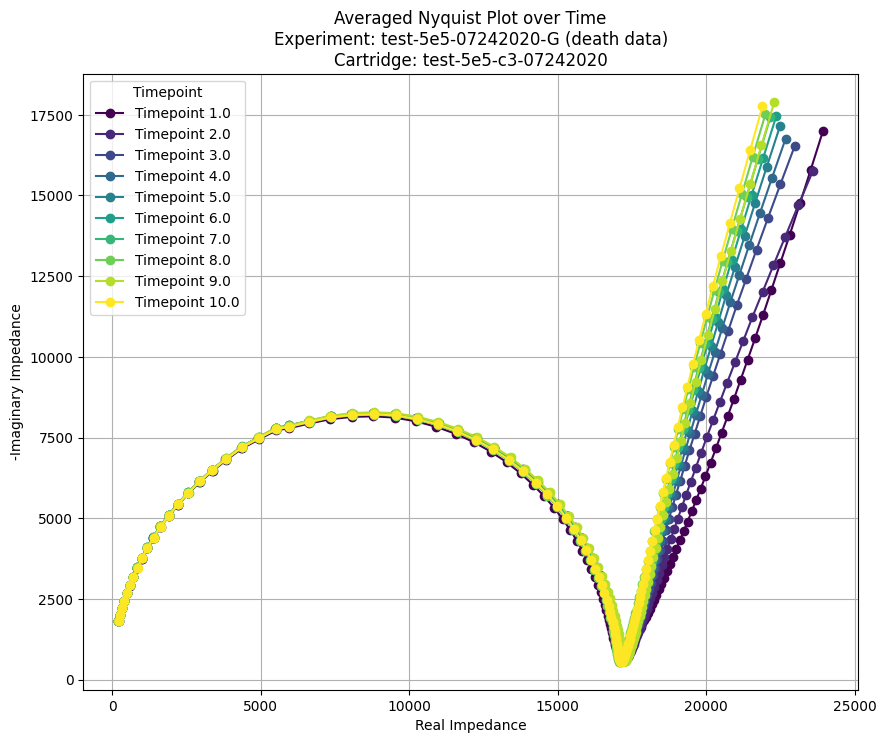


In fact from some prior experiments it can be seen that when various statistical measures of the impedance was graphed (lumped into 5 bands for simplified processing) the band1 tended to contain signal where as the other bands seemingly did not. Unless talking aoubt kurtosis for magnitude and phase. as you can see below. So to combat this I have increased the resolution and am now using 10 frequency bands instead of 5 to see if I can get slightly better resolution for what frequencies (features) matter and which don't

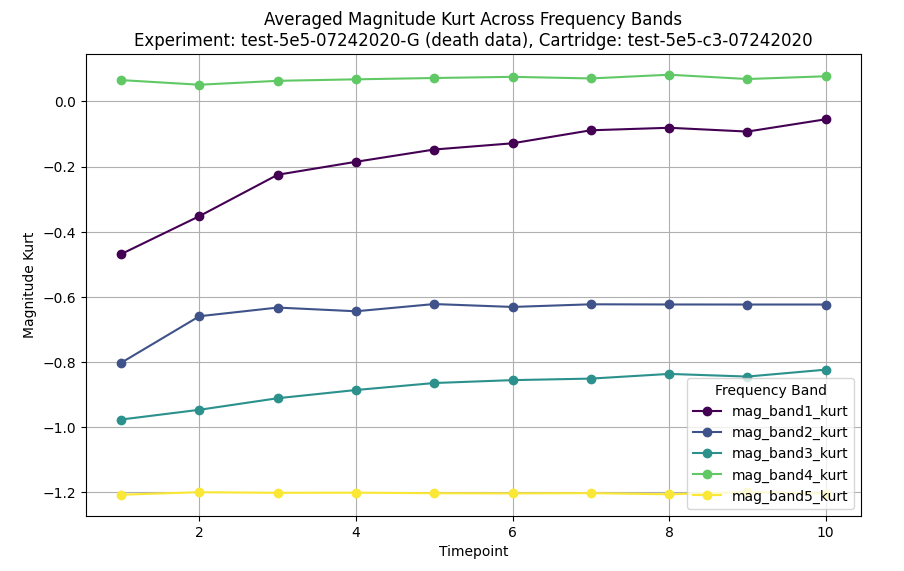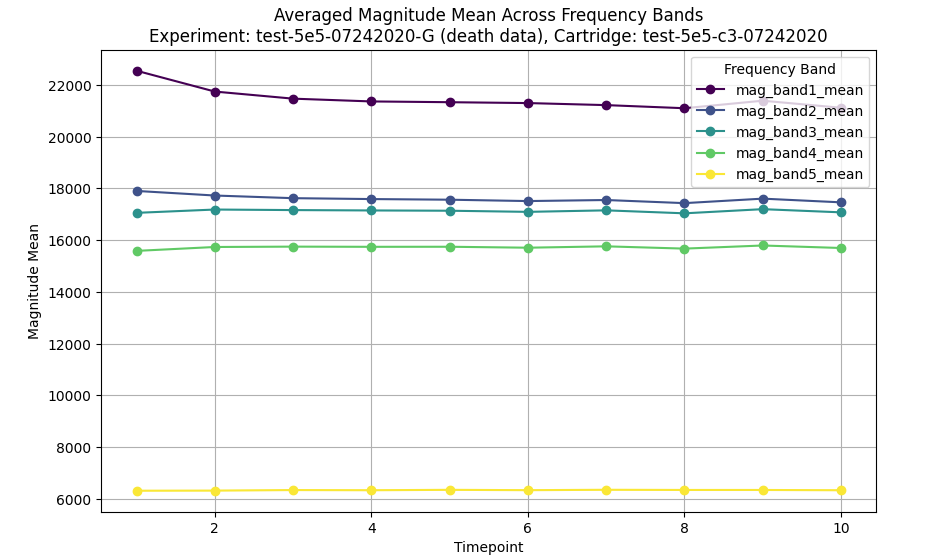

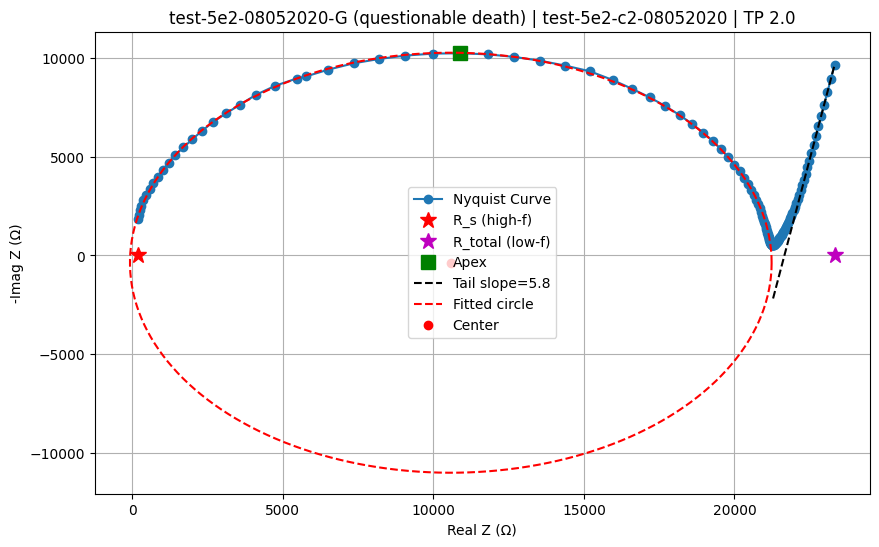

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# this will plot a random Nyquist curve from teh dataframe while annotating key features.It is MAINLY used for early debugging of prior code, but now remains as a sanity check
def plot_random_nyquist_with_features(df, window_size=5, arc_fraction=0.8):
    # pick a random row

    # 1) Select one random measurement (row) from the DataFrame
    row   = df.sample(n=1).iloc[0]
    feats = row['nyquist_features']

    # 2) Extract the sorted real (nx) and -imaginary (ny) impedance values
    nx    = np.array(feats['nyquist_x'], dtype=float)
    ny    = np.array(feats['nyquist_y'], dtype=float)
    f_sorted = nx  # real-impedance sorted array

    plt.figure(figsize=(10, 6)) # Prepare a new figure
    plt.plot(nx, ny, 'o-', label='Nyquist Curve') # Plot the Nyquist curve: real vs. -imaginary impedance

    # intercepts
    plt.plot(feats['R_s'], 0, 'r*', markersize=12, label='R_s (high‑f)') # 3) Mark the high-frequency intercept R_s
    plt.plot(feats['R_total'], 0, 'm*', markersize=12, label='R_total (low‑f)') # 4) Mark the low-frequency intercept R_total

    # 5) Identify and mark the apex (peak) of the semicircle arc
    arc_end = int(arc_fraction * len(nx))     # only consider the first fraction of points for the arc
    arc_y   = ny[:arc_end]                    # arc portion of the curve
    arc_x   = nx[:arc_end]
    if arc_y.size:
        apex_idx = np.argmax(arc_y)            # index of maximum imaginary value on the arc
        plt.plot(arc_x[apex_idx], arc_y[apex_idx], 'gs', markersize=10, label='Apex')

    # 6) Compute the slope of the “tail” region (Warburg tail)
    dydx   = np.gradient(ny, nx)
    # **Use an integer window_size here**:
    kern   = np.ones(window_size) / window_size
    smooth = np.convolve(dydx, kern, mode='same') # as before this is a mothing average so smooth it all out

    # find first index where derivative crosses from negative to non-negative
    cand   = next((i for i in range(1, len(smooth)) if smooth[i-1]<0<=smooth[i]), None)
    tail_start = cand if (cand is not None and cand<arc_end) else arc_end

    # 7) Fit a line to the last 10 tail points to get the tail slope
    tx = nx[tail_start:]
    ty = ny[tail_start:]
    if tx.size >= 10:
        lr = LinearRegression().fit(tx[-10:].reshape(-1,1), ty[-10:])
        x_fit = np.linspace(tx.min(), tx.max(), 100)
        y_fit = lr.coef_[0] * x_fit + lr.intercept_
        plt.plot(x_fit, y_fit, 'k--', label=f'Tail slope={lr.coef_[0]:.3g}')

    # 8) Plot the fitted circle over the arc portion
    xc, yc = feats['circle_center']
    Rc     = feats['circle_radius']
    if not np.isnan(Rc):
        theta = np.linspace(0, 2*np.pi, 200)
        cx = xc + Rc * np.cos(theta)
        cy = yc + Rc * np.sin(theta)
        plt.plot(cx, cy, 'r--', label='Fitted circle')
        plt.plot(xc, yc, 'ro', markersize=6, label='Center')

    # 9) Finalize plot labels and title
    plt.xlabel("Real Z (Ω)")
    plt.ylabel("-Imag Z (Ω)")
    plt.title(f"{row['experiment']} | {row['cartridge']} | TP {row['timepoint']}")
    plt.legend()
    plt.grid(True)
    plt.show()

# usage:
plot_random_nyquist_with_features(df_avg)


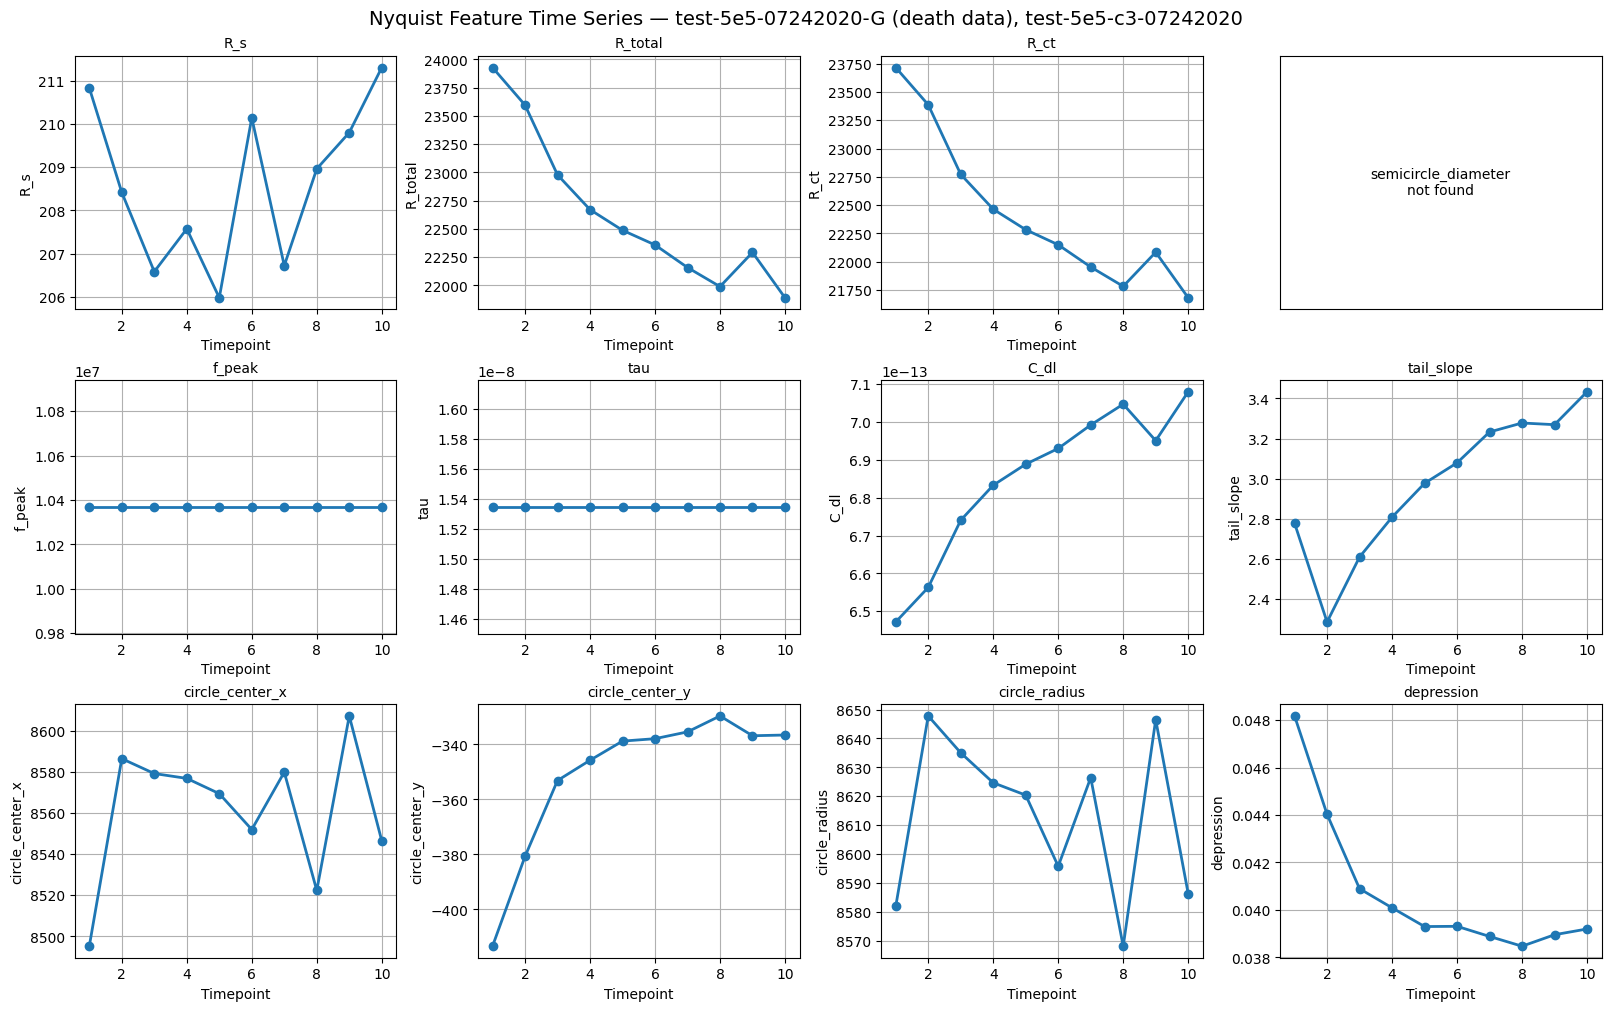

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# --- (1) Split circle_center into x & y columns ---
# This assumes features_df_raw already has a column 'circle_center' that is a list [x, y].
features_df_raw['circle_center_x'] = features_df_raw['circle_center'].apply(
    lambda c: c[0] if isinstance(c, (list, tuple)) and len(c) >= 1 else np.nan
)
features_df_raw['circle_center_y'] = features_df_raw['circle_center'].apply(
    lambda c: c[1] if isinstance(c, (list, tuple)) and len(c) >= 2 else np.nan
)

# --- (2) Now pick your experiment + cartridge subset ---
experiment = "test-5e5-07242020-G (death data)"
cartridge  = "test-5e5-c3-07242020"

df_sub = features_df_raw[
    (features_df_raw['experiment'] == experiment) &
    (features_df_raw['cartridge']  == cartridge)
].copy().sort_values("timepoint")

timepoints = df_sub['timepoint'].values

# --- (3) Define the 12 Nyquist features you want to plot ---
metrics = [
    'R_s', 'R_total', 'R_ct', 'semicircle_diameter',
    'f_peak', 'tau', 'C_dl', 'tail_slope',
    'circle_center_x', 'circle_center_y',
    'circle_radius', 'depression'
]

# --- (4) Build a 3×4 grid and plot each series ---
fig, axs = plt.subplots(3, 4, figsize=(16, 10), constrained_layout=True)

for idx, metric in enumerate(metrics):
    ax = axs[idx // 4, idx % 4]
    if metric in df_sub.columns:
        ax.plot(timepoints, df_sub[metric], 'o-', linewidth=2)
        ax.set_title(metric, fontsize=10)
        ax.set_xlabel("Timepoint")
        ax.set_ylabel(metric)
        ax.grid(True)
    else:
        ax.text(0.5, 0.5, f"{metric}\nnot found",
                ha='center', va='center', fontsize=10)
        ax.set_xticks([])
        ax.set_yticks([])

plt.suptitle(f"Nyquist Feature Time Series — {experiment}, {cartridge}", fontsize=14)
plt.show()


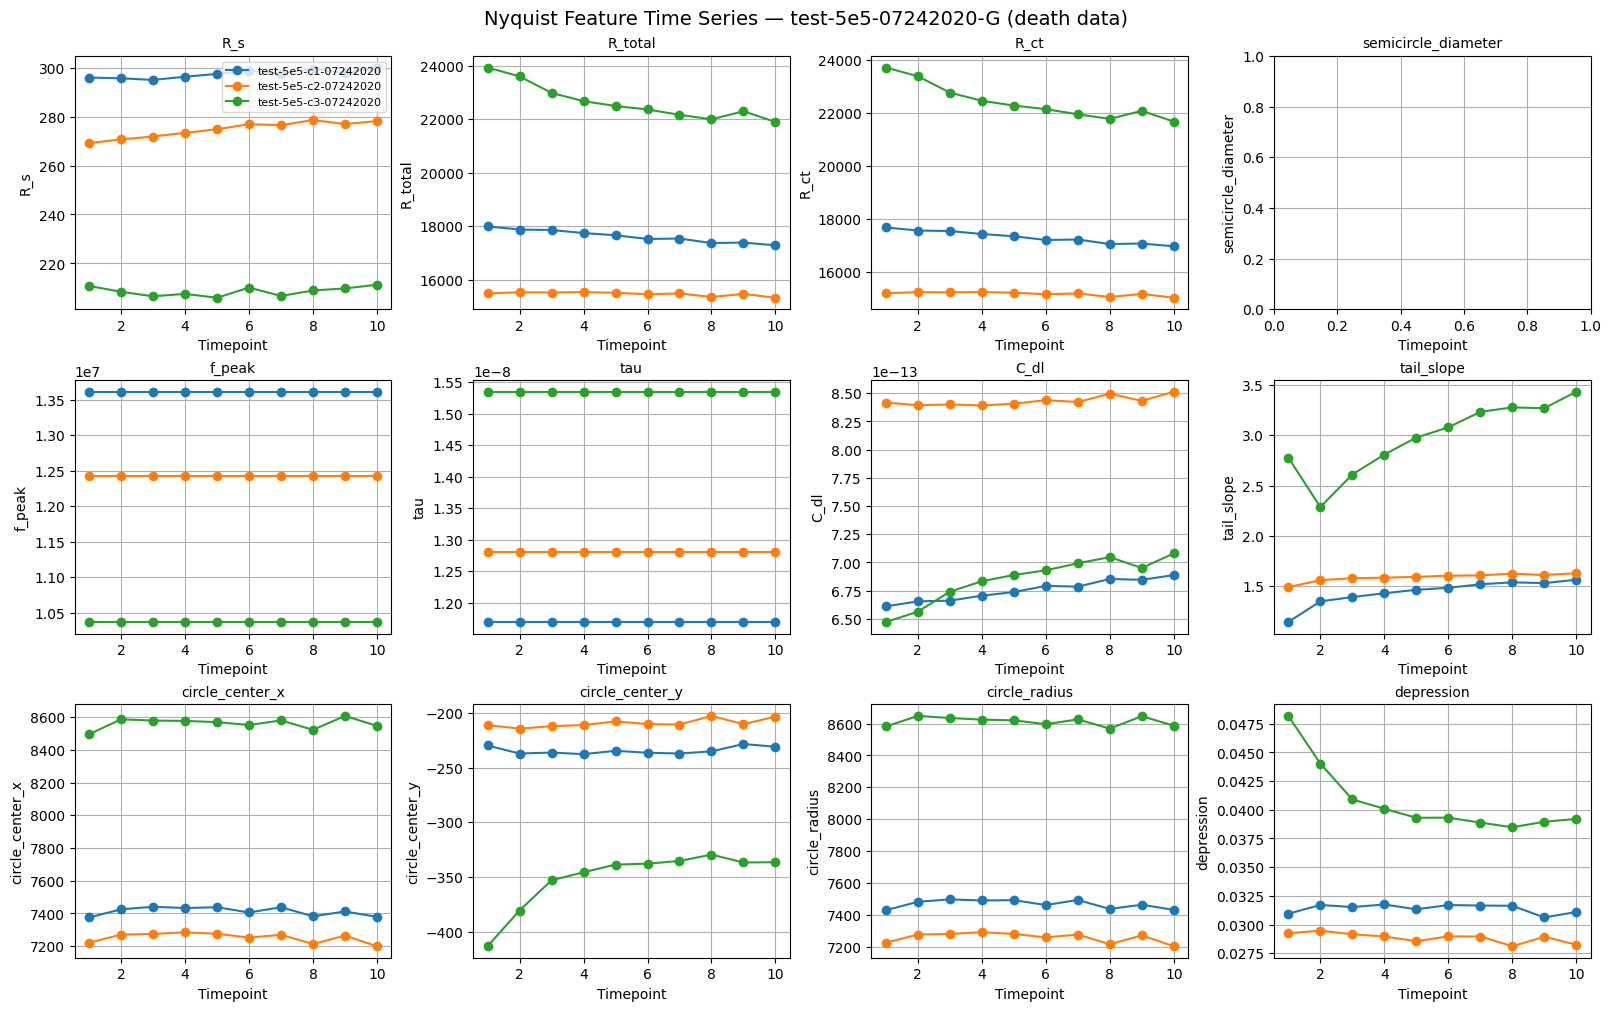

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# --- (1) Split circle_center into x & y columns ---
features_df_raw['circle_center_x'] = features_df_raw['circle_center'].apply(
    lambda c: c[0] if isinstance(c, (list, tuple)) and len(c) >= 1 else np.nan
)
features_df_raw['circle_center_y'] = features_df_raw['circle_center'].apply(
    lambda c: c[1] if isinstance(c, (list, tuple)) and len(c) >= 2 else np.nan
)

# --- (2) Pick one experiment (all its cartridges) ---
experiment = "test-5e5-07242020-G (death data)"
df_exp = (
    features_df_raw[features_df_raw['experiment'] == experiment]
    .copy()
    .sort_values(["cartridge","timepoint"])
)

# get list of cartridges in this experiment
cartridges = df_exp['cartridge'].unique()

# --- (3) Define the 12 Nyquist metrics to plot ---
metrics = [
    'R_s', 'R_total', 'R_ct', 'semicircle_diameter',
    'f_peak', 'tau', 'C_dl', 'tail_slope',
    'circle_center_x', 'circle_center_y',
    'circle_radius', 'depression'
]

# choose a color per cartridge
colors = plt.cm.tab10.colors
color_map = {cart: colors[i % len(colors)] for i, cart in enumerate(cartridges)}

# --- (4) Build 3×4 grid and plot each cartridge’s series ---
fig, axs = plt.subplots(3, 4, figsize=(16, 10), constrained_layout=True)

for idx, metric in enumerate(metrics):
    ax = axs[idx // 4, idx % 4]
    for cart in cartridges:
        sub = df_exp[df_exp['cartridge'] == cart]
        if metric in sub.columns:
            ax.plot(sub['timepoint'], sub[metric],
                    marker='o', linestyle='-',
                    color=color_map[cart],
                    label=cart)
    ax.set_title(metric, fontsize=10)
    ax.set_xlabel("Timepoint")
    ax.set_ylabel(metric)
    ax.grid(True)
    if idx == 0:
        # only draw legend once, on the first subplot
        ax.legend(loc='upper right', fontsize=8)

plt.suptitle(f"Nyquist Feature Time Series — {experiment}", fontsize=14)
plt.show()


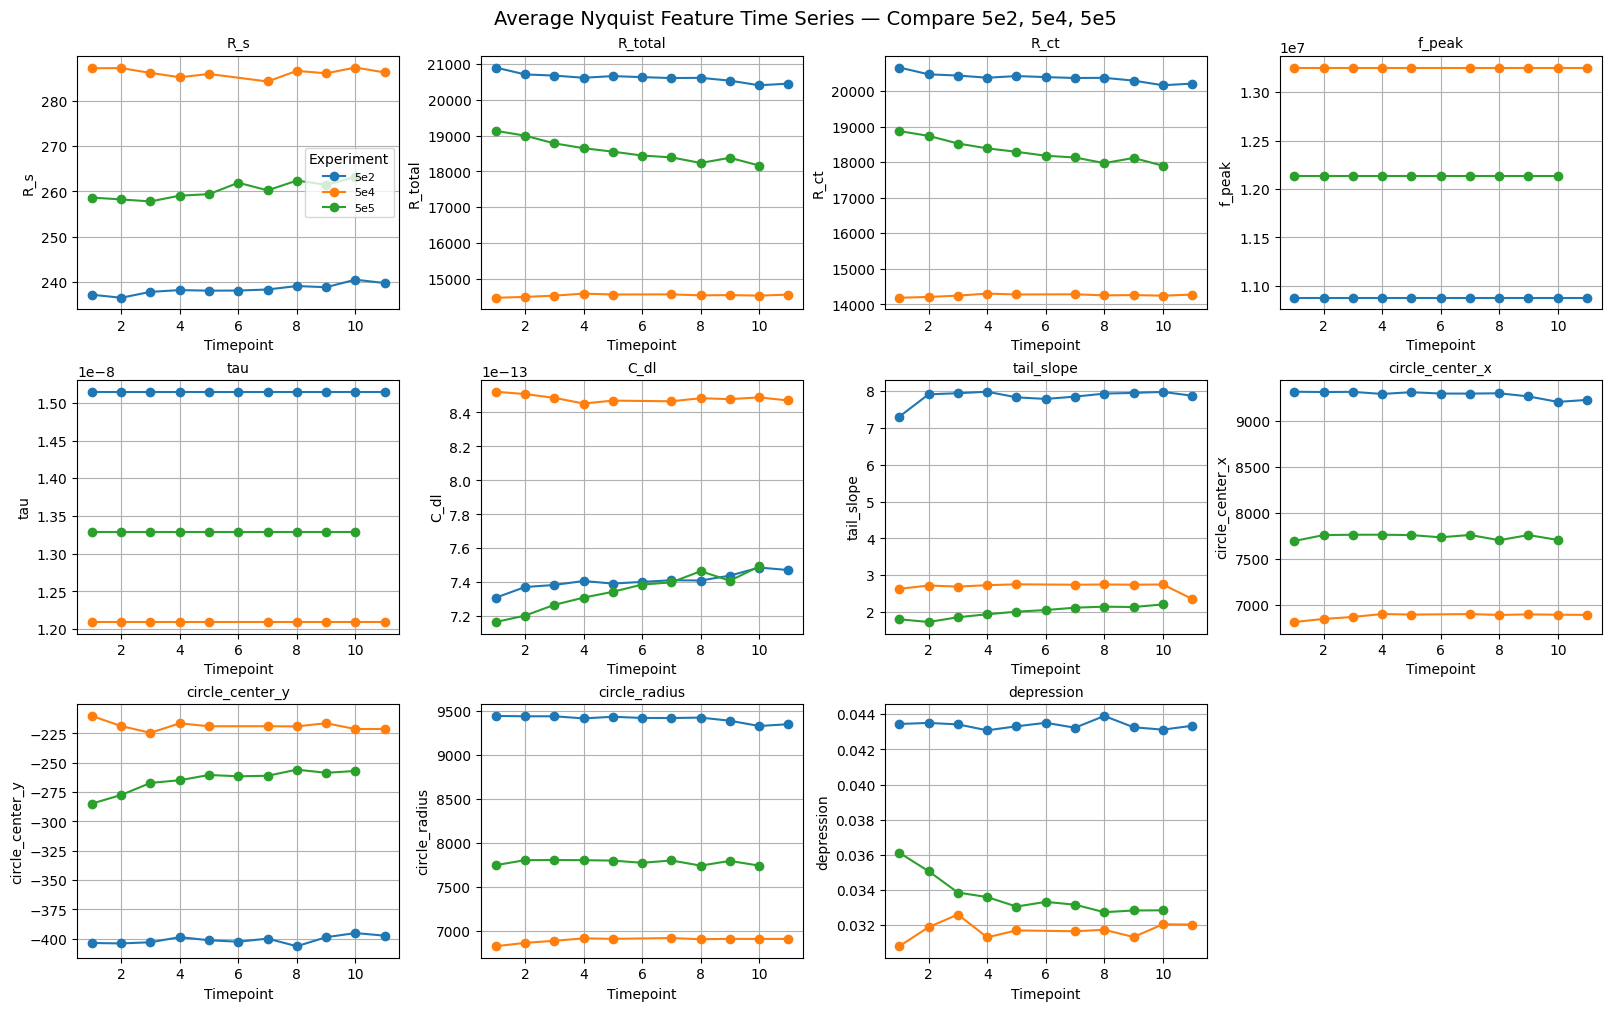

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# --- (0) If not already done, split circle_center into x & y columns ---
features_df_raw['circle_center_x'] = features_df_raw['circle_center'].apply(
    lambda c: c[0] if isinstance(c, (list, tuple)) and len(c) >= 1 else np.nan
)
features_df_raw['circle_center_y'] = features_df_raw['circle_center'].apply(
    lambda c: c[1] if isinstance(c, (list, tuple)) and len(c) >= 2 else np.nan
)

# --- (1) Define the experiments to compare ---
experiments = {
    "5e2": "test-5e2-08052020-G (questionable death)",
    "5e4": "test-5e4-07232020-G (Death data)",
    "5e5": "test-5e5-07242020-G (death data)"
}

# --- (2) The 11 Nyquist metrics to plot (semicircle removed) ---
metrics = [
    'R_s', 'R_total', 'R_ct',
    'f_peak', 'tau', 'C_dl', 'tail_slope',
    'circle_center_x', 'circle_center_y',
    'circle_radius', 'depression'
]

# --- (3) Set up colors for each experiment ---
colors  = plt.cm.tab10.colors
exp_keys = list(experiments.keys())
color_map = {k: colors[i % len(colors)] for i, k in enumerate(exp_keys)}

# --- (4) Plot: 3×4 grid, one subplot per metric, drop unused axes ---
n_rows, n_cols = 3, 4
fig, axs = plt.subplots(n_rows, n_cols, figsize=(16, 10), constrained_layout=True)
axes = axs.flatten()

for idx, metric in enumerate(metrics):
    ax = axes[idx]
    for key in exp_keys:
        label = experiments[key]
        df_exp = (
            features_df_raw
            .loc[features_df_raw['experiment'] == label, ['timepoint', metric]]
            .dropna(subset=[metric])
        )
        if df_exp.empty:
            continue
        # average across cartridges by timepoint
        df_mean = (
            df_exp
            .groupby('timepoint')[metric]
            .mean()
            .reset_index()
            .sort_values('timepoint')
        )
        ax.plot(
            df_mean['timepoint'],
            df_mean[metric],
            marker='o',
            linestyle='-',
            color=color_map[key],
            label=key
        )
    ax.set_title(metric, fontsize=10)
    ax.set_xlabel("Timepoint")
    ax.set_ylabel(metric)
    ax.grid(True)
    if idx == 0:
        ax.legend(title="Experiment", fontsize=8)

# remove any leftover empty subplots
for j in range(len(metrics), n_rows*n_cols):
    fig.delaxes(axes[j])

plt.suptitle(
    "Average Nyquist Feature Time Series — Compare 5e2, 5e4, 5e5",
    fontsize=14
)
plt.show()


now we need to calculate it all again using the normalized data.

In [9]:
import numpy as np
import pandas as pd



# define a helper to Z‑normalize each row’s real & imag
#
def znormalize_traces(row): # currently not dividing by std because I am worried about distorting the shapes of the nyquist graphs (as they likely contain signal (though I have yet to truly prove this))
    """
    Complex‐magnitude normalization to preserve Nyquist shape.
    """
    real = np.array(row['trace_A']['real'], dtype=float)
    imag = np.array(row['trace_B']['img'],  dtype=float)
    freq = row['trace_A']['frequency']

    # Build complex spectrum and normalize by max |Z|
    Z = real + 1j * imag
    max_mag = np.abs(Z).max()
    if max_mag == 0:
        max_mag = 1.0
    real_norm = (real / max_mag).tolist()
    imag_norm = (imag / max_mag).tolist()

    return pd.Series({
        'trace_A_norm': {'frequency': freq, 'real': real_norm},
        'trace_B_norm': {'frequency': freq, 'img' : imag_norm}
    })

# apply per‐row normalization
normed = df_avg.apply(znormalize_traces, axis=1)
df_avg['trace_A_norm'] = normed['trace_A_norm']
df_avg['trace_B_norm'] = normed['trace_B_norm']

# - build a normalized‐spectra copy for downstream feature extraction
df_norm = df_avg.copy()
df_norm['trace_A'] = df_norm['trace_A_norm']
df_norm['trace_B'] = df_norm['trace_B_norm']

# now df_norm contains Z‑normalized real & imag in ['trace_A','trace_B']


In [10]:
def compute_nyquist_simple(row, window_size=5, arc_fraction=0.8):
    """
    Unified Nyquist feature extractor with fixed sort, intercepts,
    breakpoint logic, last‑10 unpack, and circle‑fit.
    """
    import numpy as np
    from sklearn.linear_model import LinearRegression

    freq = np.array(row['trace_A']['frequency'], dtype=float)
    zr   = np.array(row['trace_A']['real'],      dtype=float)
    zi   = np.array(row['trace_B']['img'],       dtype=float)

    # sort by real(Z)
    order = np.argsort(zr)
    nx     = zr[order]
    ny     = -zi[order]
    f_sorted = freq[order]

    # intercepts
    R_s     = nx[0]
    R_total = nx[-1]
    R_ct    = R_total - R_s
    semicircle_diameter = R_ct

    # gradient & smoothing
    dydx   = np.gradient(ny, nx)
    kernel = np.ones(window_size) / window_size
    smooth = np.convolve(dydx, kernel, mode='same')

    # arc/tail breakpoint
    cutoff = int(arc_fraction * len(nx))
    if (candidate := next((i for i in range(1, len(smooth)) if smooth[i-1] < 0 <= smooth[i]), None)) is not None and candidate < cutoff:
        tail_start = candidate
    else:
        tail_start = cutoff

    # apex & f_peak
    arc_y = ny[:tail_start]; arc_f = f_sorted[:tail_start]
    f_peak = arc_f[np.argmax(arc_y)] if arc_y.size else np.nan

    # tau & C_dl
    tau  = 1/(2*np.pi*f_peak) if f_peak > 0 else np.nan
    C_dl = tau / R_ct     if (tau > 0 and R_ct > 0) else np.nan

    # tail slope
    if len(nx) >= 10:
        tx, ty = nx[-10:], ny[-10:]
        tail_slope = LinearRegression().fit(tx.reshape(-1,1), ty).coef_[0]
    else:
        tail_slope = np.nan

    # circle fit on arc portion
    arc_x = nx[:tail_start]; arc_y_fit = ny[:tail_start]
    try:
        A = np.column_stack((2*arc_x, 2*arc_y_fit, np.ones_like(arc_x)))
        b = arc_x**2 + arc_y_fit**2
        x_c, y_c, c = np.linalg.lstsq(A, b, rcond=None)[0]
        R_circle = np.sqrt(x_c**2 + y_c**2 + c)
    except:
        x_c = y_c = R_circle = np.nan

    # depression metric
    depression = -y_c / R_circle if (R_circle > 0 and not np.isnan(y_c)) else np.nan

    return {
        'nyquist_x':           nx.tolist(),
        'nyquist_y':           ny.tolist(),
        'R_s':                 R_s,
        'R_total':             R_total,
        'R_ct':                R_ct,
        'semicircle_diameter': semicircle_diameter,
        'f_peak':              f_peak,
        'tau':                 tau,
        'C_dl':                C_dl,
        'tail_slope':          tail_slope,
        'circle_center_x':     x_c,
        'circle_center_y':     y_c,
        'circle_radius':       R_circle,
        'depression':          depression
    }


# --- 2) now apply to your normalized‐spectra df_norm ---
df_norm['mag_phase']       = df_norm.apply(compute_mag_phase, axis=1)
df_norm['band_stats']      = df_norm.apply(compute_band_stats_nested, axis=1)
df_norm['nyquist_features']= df_norm.apply(compute_nyquist_simple, axis=1)

# --- 3) flatten into one table again ---
base   = df_norm[['experiment','cartridge','timepoint','exp_key','CPEb-T(+)']]
nyq_df = pd.json_normalize(df_norm['nyquist_features'])
band_df= pd.DataFrame(df_norm['band_stats'].apply(lambda bs:
            {f"{b}_{k}":v
             for b,stats in bs.items()
             for k,v in (stats or {}).items()}
         ).tolist())

features_norm = pd.concat([base.reset_index(drop=True),
                           nyq_df.reset_index(drop=True),
                           band_df.reset_index(drop=True)],
                          axis=1)

print("Normalized‐based features:", features_norm.shape)
features_norm.head()


Normalized‐based features: (197, 99)


,experiment,cartridge,timepoint,exp_key,CPEb-T(+),nyquist_x,nyquist_y,R_s,R_total,R_ct,...,band9_phase_skew,band9_phase_kurt,band10_mag_mean,band10_mag_var,band10_mag_skew,band10_mag_kurt,band10_phase_mean,band10_phase_var,band10_phase_skew,band10_phase_kurt
0,contorl test-no bacteria,control-c1-06262020,1,1-1-1,1.25476e-12,"[0.020948059386863296, 0.024628243134023977, 0...","[0.13720602089152542, 0.14938932083423107, 0.1...",0.0209480594,0.990788544,0.969840484,...,0.1255594,-1.22068084,0.204938134,0.00170312421,0.186007532,-1.24216733,-1.35253595,0.00241078373,0.553378693,-1.06993052
1,contorl test-no bacteria,control-c1-06262020,2,1-2-3,1.25666e-12,"[0.020853988298336654, 0.02446361382828879, 0....","[0.1367980934910012, 0.14889496785908551, 0.16...",0.0208539883,0.991179291,0.970325303,...,0.127503466,-1.2196156,0.204173631,0.00168601727,0.186403849,-1.23957418,-1.35326633,0.00237781708,0.542697876,-1.08264523
2,contorl test-no bacteria,control-c1-06262020,3,1-3-1,1.26052e-12,"[0.020771980771971975, 0.02435746221316216, 0....","[0.13666419815976388, 0.14879532513439112, 0.1...",0.0207719808,0.991256318,0.970484337,...,0.127219037,-1.21953415,0.204140943,0.00168780393,0.182728885,-1.23937736,-1.35372752,0.00239947009,0.540373167,-1.09340969
3,contorl test-no bacteria,control-c1-06262020,4,1-4-1,1.26096e-12,"[0.0208857139318977, 0.024500715308089557, 0.0...","[0.13714002967377525, 0.14931037366063163, 0.1...",0.0208857139,0.99127318,0.970387466,...,0.126101211,-1.21973757,0.204834395,0.00169705688,0.18293466,-1.23706518,-1.35303477,0.00241590516,0.532698747,-1.09904284
4,contorl test-no bacteria,control-c1-06262020,5,1-5-3,1.26642e-12,"[0.020786855915251364, 0.024320770973796847, 0...","[0.13666085433138844, 0.14876790838162332, 0.1...",0.0207868559,0.991339135,0.970552279,...,0.127374236,-1.21766198,0.204121783,0.0016850532,0.183292387,-1.22872161,-1.3536799,0.00240073724,0.516953849,-1.12350175


In [11]:
df_norm.info()
features_norm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 197 entries, 0 to 196
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   experiment        197 non-null    object 
 1   cartridge         197 non-null    object 
 2   timepoint         197 non-null    float64
 3   trace_A           197 non-null    object 
 4   trace_B           197 non-null    object 
 5   exp_key           197 non-null    object 
 6   CPEb-T(+)         197 non-null    float64
 7   mag_phase         197 non-null    object 
 8   band_stats        197 non-null    object 
 9   nyquist_features  197 non-null    object 
 10  trace_A_norm      197 non-null    object 
 11  trace_B_norm      197 non-null    object 
dtypes: float64(2), object(10)
memory usage: 18.6+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 197 entries, 0 to 196
Data columns (total 99 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --


===== RAW FEATURES: 93 numeric features → 93 PCs =====


,PC,Explained %,Cum. %
0,PC1,35.9002277,35.9002277
1,PC2,23.3356267,59.2358545
2,PC3,14.3750014,73.6108559
3,PC4,7.60687486,81.2177308
4,PC5,4.94521115,86.1629419
5,PC6,3.54540067,89.7083426
6,PC7,1.92447945,91.632822
7,PC8,1.7118333,93.3446553
8,PC9,1.19555103,94.5402064
9,PC10,0.876419736,95.4166261


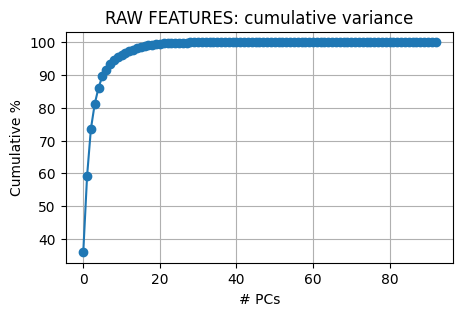

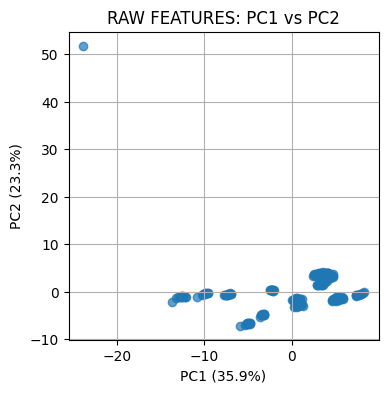


===== NORMALISED FEATURES: 92 numeric features → 92 PCs =====


,PC,Explained %,Cum. %
0,PC1,45.3503184,45.3503184
1,PC2,17.9994736,63.349792
2,PC3,12.9281247,76.2779167
3,PC4,7.32015039,83.5980671
4,PC5,4.44882502,88.0468921
5,PC6,2.22055919,90.2674513
6,PC7,1.97622414,92.2436754
7,PC8,1.68381559,93.927491
8,PC9,1.14399813,95.0714891
9,PC10,0.832305719,95.9037948


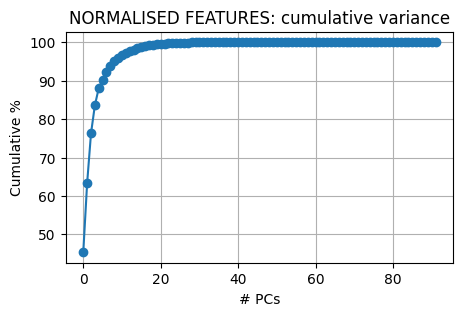

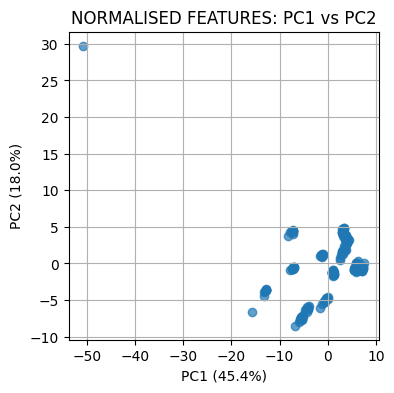


---- RAW FEATURES: top 15 variables for PC1 (explains 35.90 %) ----


,Loading,Abs load,Var share,Percent
band10_phase_mean,+0.1526,0.1526,0.0233,8.0 %
band8_mag_kurt,+0.1505,0.1505,0.0226,7.8 %
band1_phase_mean,+0.1474,0.1474,0.0217,7.5 %
band1_mag_mean,-0.1429,0.1429,0.0204,7.0 %
band2_phase_mean,+0.1402,0.1402,0.0197,6.8 %
band1_phase_var,-0.1396,0.1396,0.0195,6.7 %
band7_mag_var,-0.1392,0.1392,0.0194,6.7 %
band3_phase_mean,+0.1388,0.1388,0.0193,6.6 %
band4_phase_mean,+0.1357,0.1357,0.0184,6.3 %
band9_phase_mean,+0.1357,0.1357,0.0184,6.3 %



---- RAW FEATURES: top 15 variables for PC2 (explains 23.34 %) ----


,Loading,Abs load,Var share,Percent
C_dl,+0.2079,0.2079,0.0432,10.6 %
band5_phase_var,+0.1910,0.1910,0.0365,9.0 %
band7_phase_skew,+0.1789,0.1789,0.0320,7.9 %
band6_phase_var,+0.1764,0.1764,0.0311,7.7 %
depression,-0.1691,0.1691,0.0286,7.0 %
band7_phase_kurt,-0.1641,0.1641,0.0269,6.6 %
circle_center_y,+0.1635,0.1635,0.0267,6.6 %
band7_phase_var,+0.1588,0.1588,0.0252,6.2 %
band7_phase_mean,-0.1578,0.1578,0.0249,6.1 %
band6_phase_mean,-0.1528,0.1528,0.0233,5.7 %



---- NORMALISED FEATURES: top 15 variables for PC1 (explains 45.35 %) ----


,Loading,Abs load,Var share,Percent
band3_phase_mean,+0.1479,0.1479,0.0219,7.0 %
band2_phase_mean,+0.1477,0.1477,0.0218,7.0 %
band4_phase_mean,+0.1470,0.1470,0.0216,7.0 %
band1_phase_mean,+0.1460,0.1460,0.0213,6.9 %
R_total,+0.1441,0.1441,0.0208,6.7 %
band7_mag_mean,+0.1434,0.1434,0.0206,6.6 %
band6_mag_mean,+0.1434,0.1434,0.0206,6.6 %
band5_mag_mean,+0.1431,0.1431,0.0205,6.6 %
band1_mag_mean,+0.1430,0.1430,0.0204,6.6 %
band4_mag_mean,+0.1430,0.1430,0.0204,6.6 %



---- NORMALISED FEATURES: top 15 variables for PC2 (explains 18.00 %) ----


,Loading,Abs load,Var share,Percent
band8_mag_var,+0.1984,0.1984,0.0394,9.1 %
band7_mag_var,+0.1880,0.1880,0.0353,8.2 %
band5_phase_var,+0.1879,0.1879,0.0353,8.2 %
band7_phase_kurt,-0.1797,0.1797,0.0323,7.5 %
band7_phase_skew,+0.1788,0.1788,0.0320,7.4 %
band6_phase_skew,+0.1704,0.1704,0.0290,6.7 %
band9_phase_kurt,+0.1684,0.1684,0.0284,6.6 %
band9_phase_var,-0.1664,0.1664,0.0277,6.4 %
band9_mag_kurt,+0.1640,0.1640,0.0269,6.3 %
band7_phase_var,+0.1603,0.1603,0.0257,6.0 %


In [12]:
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
from sklearn.pipeline      import make_pipeline
from sklearn.impute        import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# -------------------------------------------------
# helper 1: keep only useful numeric columns
# -------------------------------------------------
def _numeric(df: pd.DataFrame) -> pd.DataFrame:
    num = df.select_dtypes(include=["number"]).copy()
    num.dropna(axis=1, how="all", inplace=True)          # all‑NaN → drop
    const = num.nunique(dropna=True) <= 1                # zero variance → drop
    num.drop(columns=const[const].index, inplace=True)
    return num

# -------------------------------------------------
# helper 2: run PCA + quick diagnostic plots
# -------------------------------------------------
def run_pca(df: pd.DataFrame, tag: str, n_components=None):
    X = _numeric(df)
    if X.empty:
        raise ValueError(f"{tag} has no usable numeric columns!")

    pipe = make_pipeline(
        SimpleImputer(strategy="median"),
        StandardScaler(),
        PCA(n_components=n_components)
    )
    X_pca = pipe.fit_transform(X)
    pca   = pipe[-1]

    # variance table
    var_tbl = pd.DataFrame({
        "PC":          [f"PC{i+1}" for i in range(len(pca.explained_variance_ratio_))],
        "Explained %": 100*pca.explained_variance_ratio_,
        "Cum. %":      100*np.cumsum(pca.explained_variance_ratio_)
    })
    print(f"\n===== {tag}: {X.shape[1]} numeric features → {X_pca.shape[1]} PCs =====")
    display(var_tbl.head(15))

    # scree plot
    plt.figure(figsize=(5,3))
    plt.plot(var_tbl["Cum. %"], marker="o")
    plt.title(f"{tag}: cumulative variance")
    plt.xlabel("# PCs"); plt.ylabel("Cumulative %"); plt.grid(); plt.show()

    # PC1 vs PC2 scatter
    if X_pca.shape[1] >= 2:
        plt.figure(figsize=(4,4))
        plt.scatter(X_pca[:,0], X_pca[:,1], alpha=0.7)
        plt.title(f"{tag}: PC1 vs PC2")
        plt.xlabel(f"PC1 ({100*pca.explained_variance_ratio_[0]:.1f}%)")
        plt.ylabel(f"PC2 ({100*pca.explained_variance_ratio_[1]:.1f}%)")
        plt.grid(); plt.show()

    return X_pca, pca, X.columns

# -------------------------------------------------
# helper 3: show top feature loadings for a PC  (fixed)
# -------------------------------------------------
def top_loadings(pca_obj, cols, pc_idx=0, top_n=15, tag="RAW"):
    """
    Print a table of the top‑N absolute loading weights for the chosen PC.
    """
    if pc_idx >= pca_obj.components_.shape[0]:
        raise ValueError(f"PCA only has {pca_obj.components_.shape[0]} PCs")

    # Eigen‑vector for the selected PC
    load = pca_obj.components_[pc_idx]          # length == #features
    pc_var = pca_obj.explained_variance_ratio_[pc_idx]

    # Build a Series with column names so we can sort by |loading|
    load_series = pd.Series(load, index=cols)
    ser_top = load_series.abs().sort_values(ascending=False).head(top_n)

    tbl = pd.DataFrame({
        "Loading"   : load_series[ser_top.index],
        "Abs load"  : ser_top,
        "Var share" : ser_top**2
    })
    tbl["Percent"] = 100 * tbl["Var share"] / tbl["Var share"].sum()

    print(f"\n---- {tag}: top {top_n} variables for PC{pc_idx+1} "
          f"(explains {pc_var*100:.2f} %) ----")
    display(
        tbl.style.format({"Loading": "{:+.4f}",
                          "Abs load": "{:.4f}",
                          "Var share": "{:.4f}",
                          "Percent": "{:.1f} %"})
    )

# =============================================================
# 1) drop ID / non‑feature columns
# =============================================================
raw_features  = features_df_raw.drop(
    columns=["experiment","cartridge","exp_key","CPEb-T(+)","timepoint"]
)
norm_features = features_norm.drop(
    columns=["experiment","cartridge","exp_key","CPEb-T(+)","timepoint"]
)

# =============================================================
# 2) PCA on RAW and NORMALISED tables
# =============================================================
Xp_raw ,  pca_raw ,  raw_cols  = run_pca(raw_features ,  tag="RAW FEATURES")
Xp_norm,  pca_norm,  norm_cols = run_pca(norm_features, tag="NORMALISED FEATURES")

# =============================================================
# 3) Inspect loadings (PC1 and PC2) – change pc_idx / top_n as desired
# =============================================================
top_loadings(pca_raw ,  raw_cols ,  pc_idx=0, tag="RAW FEATURES")
top_loadings(pca_raw ,  raw_cols ,  pc_idx=1, tag="RAW FEATURES")

top_loadings(pca_norm,  norm_cols,  pc_idx=0, tag="NORMALISED FEATURES")
top_loadings(pca_norm,  norm_cols,  pc_idx=1, tag="NORMALISED FEATURES")


**Principal‑component analysis (PCA).**

After restricting the data set to scalar numeric features (95 in the raw table) it is clear that


Both scree plots exhibited a sharp elbow at ~10 components, indicating that the effective dimensionality of the data can be reduced from >90 variables to a compact 10‑dimensional sub‑space with minimal information loss (≈ 95 % of the original variance retained).

Normalisation therefore improved the contrast between informative and noisy directions in the data and is the representation we use in subsequent analyses (TENTATIVELY)

HOWEVER I am pretty sure tons of theres variables are linearly correlated and therefore contain redudant informatoin that will do nothing but cause models to overfit. I need to figure out which oens are linearly correlated with each other above a certain threshold and them keep only one of them.

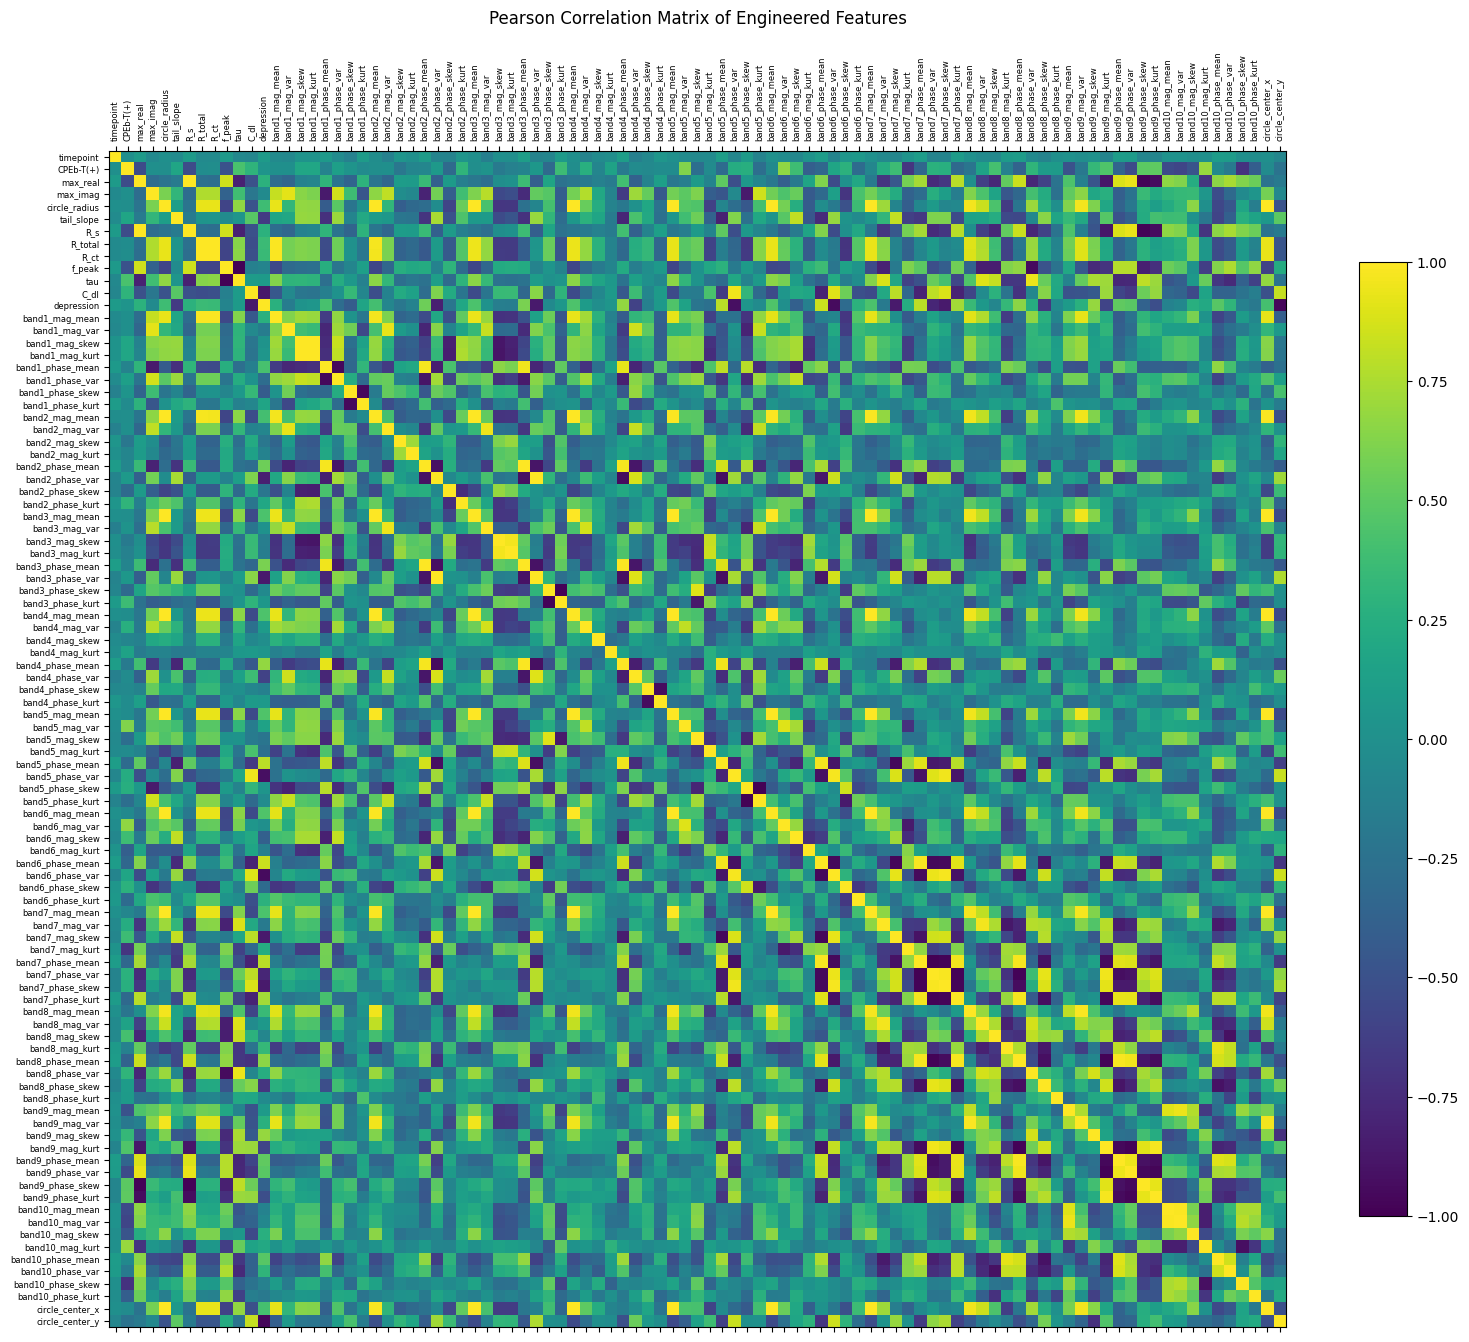

In [16]:
import numpy as np
import matplotlib.pyplot as plt

# I want to figure out within a given exp, cart, tp which calculated featuyres correlate with something greater than 95% and then remove one of them. Then the features that do that the most amount of times across all rows I will globally remove and hopefully reduce teh dimensionality of this data a little bit
features_df = features_df_raw.copy()

# 1) Grab only the numeric columns
numeric_cols = features_df.select_dtypes(include=[np.number]).columns.tolist()

# 2) Compute the Pearson correlation matrix
corr = features_df[numeric_cols].corr(method='pearson')

# 3) Plot a heatmap
fig, ax = plt.subplots(figsize=(16, 14))
cax = ax.matshow(corr, vmin=-1, vmax=1)
fig.colorbar(cax, shrink=0.75)
ax.set_xticks(range(len(numeric_cols)))
ax.set_yticks(range(len(numeric_cols)))
ax.set_xticklabels(numeric_cols, rotation=90, fontsize=6)
ax.set_yticklabels(numeric_cols, fontsize=6)
ax.set_title("Pearson Correlation Matrix of Engineered Features", pad=20)
plt.tight_layout()
plt.show()
